# SmartSat Hyperspectral Notes

#### Imports



In [2]:
## Imports

import os
import glob
import json
import joblib
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from rios import applier, fileinfo
from netCDF4 import Dataset
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull


gdal.UseExceptions()



## ENMAP

Search for [ENMAP](https://explore.eo-lab.org/search)

ENMAP comes as PIXEL interleaved COG, it's slow to open in QGIS. I run the `src/reformat_enmap.sh` shell script to reformat it to tiled BAND interleaved with tiled overviews


## EMIT

Search for [EMIT](https://earth.jpl.nasa.gov/emit/data/data-portal/coverage-and-forecasts/)

### Importing EMIT data
The `src/gdal_import_emit.py` script can be used to import EMIT data into GDAL formats, applying the GLT so the data is mapped to a grid.

### Sampling EMIT NETCDF


/tmp/ipykernel_802971/4086274589.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dat = np.array(nc_ds['reflectance'])


Mask file does not exist. Skipping masking.
Shape after removing wild values: (285, 1589739)


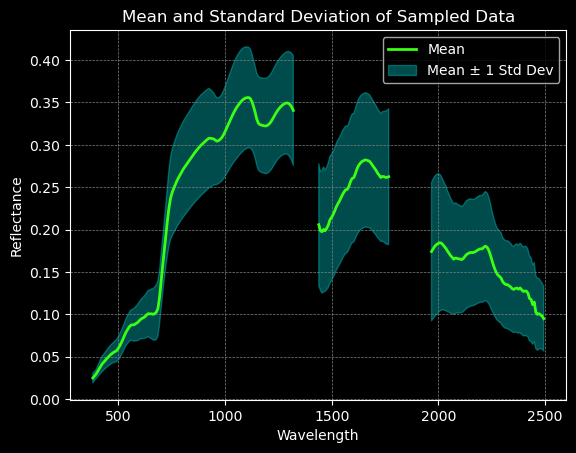

In [3]:

import numpy as np
from netCDF4 import Dataset
import os

def extract_and_mask_data(emit_file):
    mask_file = emit_file.replace('RFL', 'MASK')
    
    # Extract variables and metadata from the NetCDF file
    nc_ds = Dataset(emit_file, 'r', format='NETCDF4')
    dat = np.array(nc_ds['reflectance'])
    # Reshape/rotate to (bands, lines, columns)
    dat = np.moveaxis(dat, 2, 0)
    # Reshape to (bands, pixels)
    dat = dat.reshape((dat.shape[0], -1))
    # Create an x-axis for plotting
    wavelengths = nc_ds.groups.get('sensor_band_parameters').variables['wavelengths'][:]
    nc_ds.close()
    
    # Check if mask file exists
    if os.path.exists(mask_file):
        # Extract the mask from the NetCDF file
        nc_ds = Dataset(mask_file, 'r', format='NETCDF4')
        mask = np.array(nc_ds['mask'])
        # Aggregate mask is the 7th band
        mask = mask[:, :, 7] == 0
        # Reshape/rotate to (lines, columns)
        mask = np.moveaxis(mask, 1, 0)
        # Reshape to (pixels)
        mask = mask.reshape(-1)
        nc_ds.close()
        
        # Mask the data
        print("Original shape:", dat.shape)
        dat = dat[:, mask]
        print("Shape after masking:", dat.shape)
    else:
        print("Mask file does not exist. Skipping masking.")

    # Remove wild values
    dat = dat[:, np.max(dat, axis=0) < 0.9]
    print("Shape after removing wild values:", dat.shape)
    
    return dat, wavelengths


def plot_data(dat, wavelengths):
    # Plot the mean and standard deviation of the sampled data
    mean = np.mean(dat, axis=1)
    std_dev = np.std(dat, axis=1)

    # Mask values less than 0 by setting them to NaN
    mean[mean < 0] = np.nan
    std_dev[std_dev < 0] = np.nan

    # Set the black background
    plt.style.use('dark_background')

    # Plot the mean with a neon color
    plt.plot(wavelengths, mean, label='Mean', color='#39FF14', linewidth=2)  # Neon green line

    # Plot the standard deviation as a shaded area with a neon color
    plt.fill_between(wavelengths, mean - std_dev, mean + std_dev, color='#00FFFF', alpha=0.3, label='Mean ± 1 Std Dev')  # Neon cyan shading

    # Customize the plot with labels, title, legend, and grid
    plt.xlabel('Wavelength', color='white')
    plt.ylabel('Reflectance', color='white')
    plt.title('Mean and Standard Deviation of Sampled Data', color='white')
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()

# Usage:
emit_file = '/mnt/e/OneDrive - Cibo Labs Pty Ltd/smartsatQuality/crc_emit/EMIT_L2A_RFL_001_20241029T023511_2430302_055.nc'
dat, wavelengths = extract_and_mask_data(emit_file)
plot_data(dat, wavelengths)


## Clean the DATA

In [4]:
# Find the indicies of the bands where the minumum is all less than 0
bad_bands = np.all(dat < 0, axis=1)
print(f'Bad bands: {np.where(bad_bands)[0]}')

# Remove outliers using sklearn IsolationForest
clf = IsolationForest(contamination=0.05)
outliers = clf.fit_predict(dat.T)
sampled_data = dat[:, outliers == 1].T
# Print the proportion of outliers
print(f'Proportion of outliers: {np.sum(outliers == -1) / len(outliers)}')

# Subsample a maximum of 1 million pixels
num_samples = 1000000
sample_pixels = np.random.choice(sampled_data.shape[0], min(num_samples,sampled_data.shape[0]), replace=False)
sampled_data = sampled_data[sample_pixels]
print(sampled_data.shape)



Bad bands: [127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212]
Proportion of outliers: 0.05000003145170371
(1000000, 285)


### SMACC

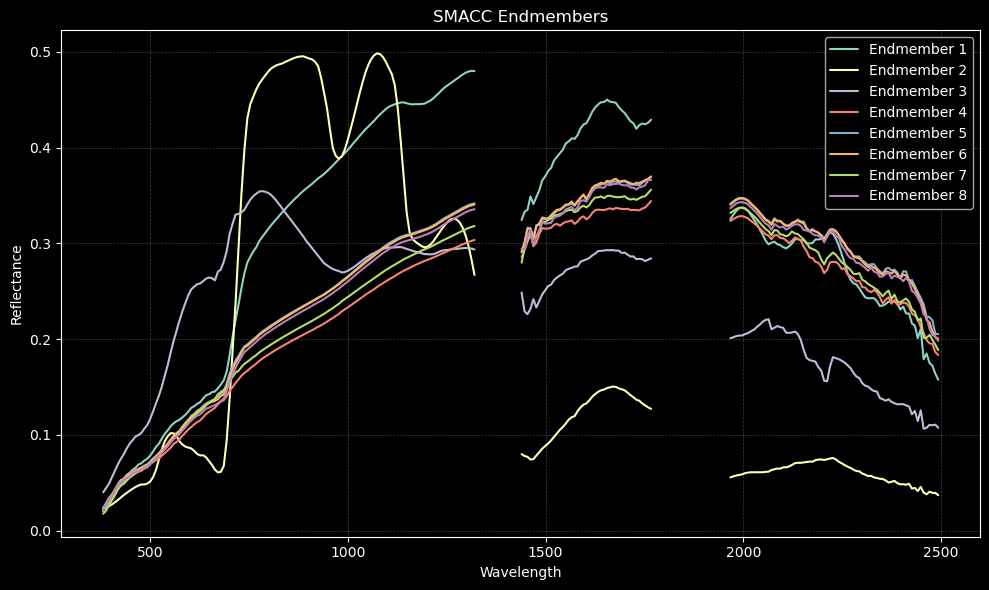

In [5]:
def smacc(spectra, min_endmembers=None, max_residual_norm=float('Inf')):
    '''Returns SMACC decomposition (H = F * S + R) matrices for an image or
    array of spectra.

    Let `H` be matrix of shape NxB, where B is number of bands, and N number of
    spectra, then if `spectra` is of the same shape, `H` will be equal to `spectra`.
    Otherwise, `spectra` is assumed to be 3D spectral image, and it is reshaped
    to match shape of `H`.

    Arguments:

        `spectra` (ndarray):

            Image data for which to calculate SMACC decomposition matrices.

        `min_endmembers` (int):

            Minimal number of endmembers to find. Defaults to rank of `H`,
            computed numerically with `numpy.linalg.matrix_rank`.

        `max_residual_norm`:

            Maximum value of residual vectors' norms. Algorithm will keep finding
            new endmembers until max value of residual norms is less than this
            argument. Defaults to float('Inf')

    Returns:
        3 matrices, S, F and R, such that H = F * S + R (but it might not always hold).
        F is matrix of expansion coefficients of shape N x num_endmembers.
        All values of F are equal to, or greater than zero.
        S is matrix of endmember spectra, extreme vectors, of shape num_endmembers x B.
        R is matrix of residuals of same shape as H (N x B).

        If values of H are large (few tousands), H = F * S + R, might not hold,
        because of numeric errors. It is advisable to scale numbers, by dividing
        by 10000, for example. Depending on how accurate you want it to be,
        you can check if H is really strictly equal to F * S + R,
        and adjust R: R = H - np.matmul(F, S).

    References:

        John H. Gruninger, Anthony J. Ratkowski, and Michael L. Hoke "The sequential
        maximum angle convex cone (SMACC) endmember model", Proc. SPIE 5425, Algorithms
        and Technologies for Multispectral, Hyperspectral, and Ultraspectral Imagery X,
        (12 August 2004); https://doi.org/10.1117/12.543794
    '''    
    # Flatten 3D spectral image to 2D if necessary
    H = spectra.reshape((-1, spectra.shape[2])) if spectra.ndim == 3 else spectra
    
    R = H.copy()
    Fs = []
    q = []  # Indices of selected vectors in S
    
    # Set default minimum endmembers
    if min_endmembers is None:
        min_endmembers = np.linalg.matrix_rank(H)

    residual_norms = np.linalg.norm(H, axis=1)
    current_max_residual_norm = np.max(residual_norms)
    
    if max_residual_norm is None:
        max_residual_norm = current_max_residual_norm / min_endmembers

    while len(q) < min_endmembers or current_max_residual_norm > max_residual_norm:
        idx = np.argmax(residual_norms)
        q.append(idx)
        
        # Calculate projection coefficients
        w = R[idx]
        wt = w / np.dot(w, w)
        On = np.dot(R, wt)
        alpha = np.ones_like(On)
        
        # Adjust alphas for oblique projection
        for k in range(len(Fs)):
            t = On * Fs[k][idx]
            t[t == 0.0] = 1e-10
            alpha = np.minimum(Fs[k] / t, alpha, where=t != 0.0)
        
        # Clip negative projection coefficients
        alpha[On <= 0.0] = 0.0
        alpha[idx] = 1.0
        
        # Calculate oblique projection coefficients
        Fn = alpha * On.clip(min=0.0)
        R -= np.outer(Fn, w)
        
        # Update existing factors
        for k in range(len(Fs)):
            Fs[k] -= Fs[k][idx] * Fn
            Fs[k] = Fs[k].clip(min=0.0)
        
        Fs.append(Fn)
        residual_norms = np.linalg.norm(R, axis=1)
        current_max_residual_norm = np.max(residual_norms)
        
        print(f'Found {len(q)} endmembers, current max residual norm is {current_max_residual_norm:.4f}\r', end='')

    # Correction as suggested in the SMACC paper.
    for k, s in enumerate(q):
        Fs[k][q] = 0.0
        Fs[k][s] = 1.0

    F = np.column_stack(Fs).T
    S = H[q]

    return S, F, R




# Use boolean indexing more efficiently by computing mask once
valid_bands = ~np.all(sampled_data < 0, axis=0)

# Get endmembers for valid bands only
S, F, R = smacc(sampled_data[:, valid_bands], min_endmembers=8, max_residual_norm=5)

# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

# Create figure
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    
    # Vectorized plotting using numpy operations
    wavelengths_matrix = np.tile(wavelengths, (endmembers.shape[0], 1)).T
    
    # Plot all lines at once with optimized line properties
    lines = ax.plot(wavelengths_matrix, endmembers.T, 
                   linewidth=1.5,  # Optimal line width for performance
                   solid_capstyle='round',
                   antialiased=True)
    
    ax.set_prop_cycle('color', plt.cm.tab10(np.linspace(0, 1, endmembers.shape[0])))
    
    ax.set(xlabel='Wavelength',
           ylabel='Reflectance',
           title='SMACC Endmembers')
    
    for text in (*ax.get_xticklabels(), *ax.get_yticklabels(),
                ax.xaxis.label, ax.yaxis.label, ax.title):
        text.set_color('white')
    
    ax.legend([f'Endmember {i+1}' for i in range(endmembers.shape[0])],
              framealpha=0.8,
              loc='best',
              ncol=1)

    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout()

### NFINDr

Cumulative PCA Explained Variance = [0.6861536  0.9598639  0.9869761  0.9922842  0.994392   0.996278
 0.99766845 0.9982656  0.9986373  0.99892783 0.99915725]


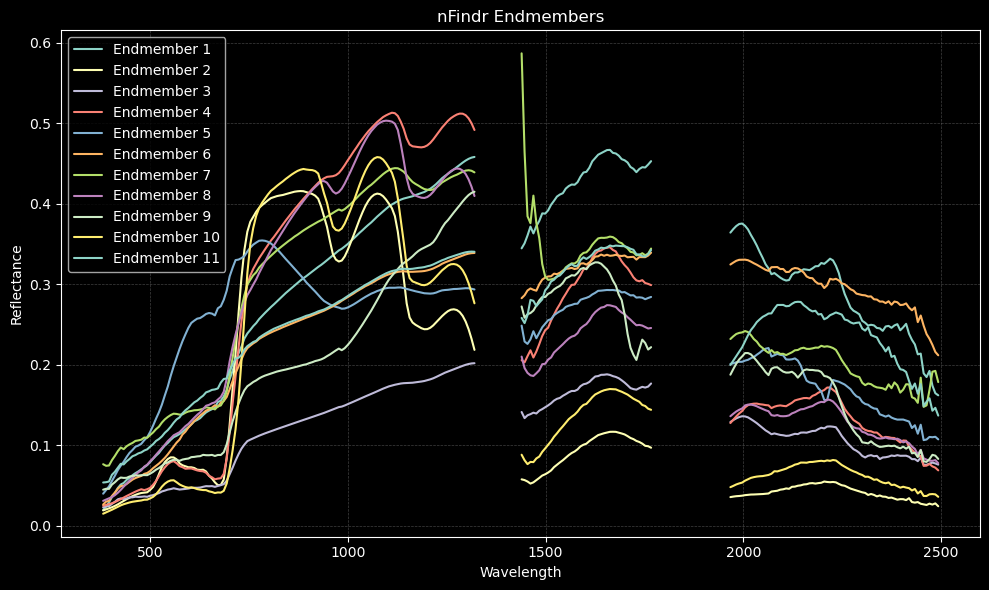

In [6]:

def nfindr(srData,n_components=0.999):
    """
    Extract endmembers from spectral data using the NFINDR algorithm.
    
    Parameters:
    - srData (ndarray): Input spectral reflectance data of shape (bands, samples).
    - nSubsets (int, optional): Number of subsets for subsampling. Defaults to None.
    
    Returns:
    - endmembers (ndarray): Detected endmember spectra.
    """

    # Compute the PCA
    pca = PCA(n_components=n_components)
    pcaData = pca.fit_transform(srData)
    
    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f'Cumulative PCA Explained Variance = {cumulative_explained_variance}')
    
    # First two endmembers are the extremes of PCA component 1
    sub = np.array([np.argmax(pcaData[:, 0]), np.argmin(pcaData[:, 0])])

    # Loop to find remaining endmembers
    for nEdge in range(3, pcaData.shape[1] + 1):
        dmax = 0
        endMatrix = np.ones(nEdge)

        for i in range(nEdge - 1):
            endMatrix = np.vstack((endMatrix, np.append(pcaData[sub, i], 0)))

        # Test every pixel to find new endmember
        for i in range(len(pcaData)):
            endMatrix[1:nEdge, nEdge - 1] = pcaData[i, 0:nEdge - 1]
            
            # Calculate volume of the simplex
            volume = np.abs(np.linalg.det(endMatrix))
            
            if volume > dmax and i not in sub:
                dmax = volume
                subn = i
        
        print(f"Completed {nEdge} search\r", end='')
        sub = np.append(sub, subn)

    # Extract the endmembers in actual reflectance
    endmembers = srData[sub]
    return endmembers

# Use boolean indexing more efficiently by computing mask once
valid_bands = ~np.all(sampled_data < 0, axis=0)

# Get endmembers for valid bands only
S = nfindr(sampled_data[:, valid_bands], 0.999)

# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

# Create figure
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    
    # Vectorized plotting using numpy operations
    wavelengths_matrix = np.tile(wavelengths, (endmembers.shape[0], 1)).T
    
    # Plot all lines at once with optimized line properties
    lines = ax.plot(wavelengths_matrix, endmembers.T, 
                   linewidth=1.5,  # Optimal line width for performance
                   solid_capstyle='round',
                   antialiased=True)
    
    ax.set_prop_cycle('color', plt.cm.tab10(np.linspace(0, 1, endmembers.shape[0])))
    
    ax.set(xlabel='Wavelength',
           ylabel='Reflectance',
           title='nFindr Endmembers')
    
    for text in (*ax.get_xticklabels(), *ax.get_yticklabels(),
                ax.xaxis.label, ax.yaxis.label, ax.title):
        text.set_color('white')
    
    ax.legend([f'Endmember {i+1}' for i in range(endmembers.shape[0])],
              framealpha=0.8,
              loc='best',
              ncol=1)

    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout()





### QHULL

Cumulative PCA Explained Variance = [0.6861536 0.9598639 0.9869761]


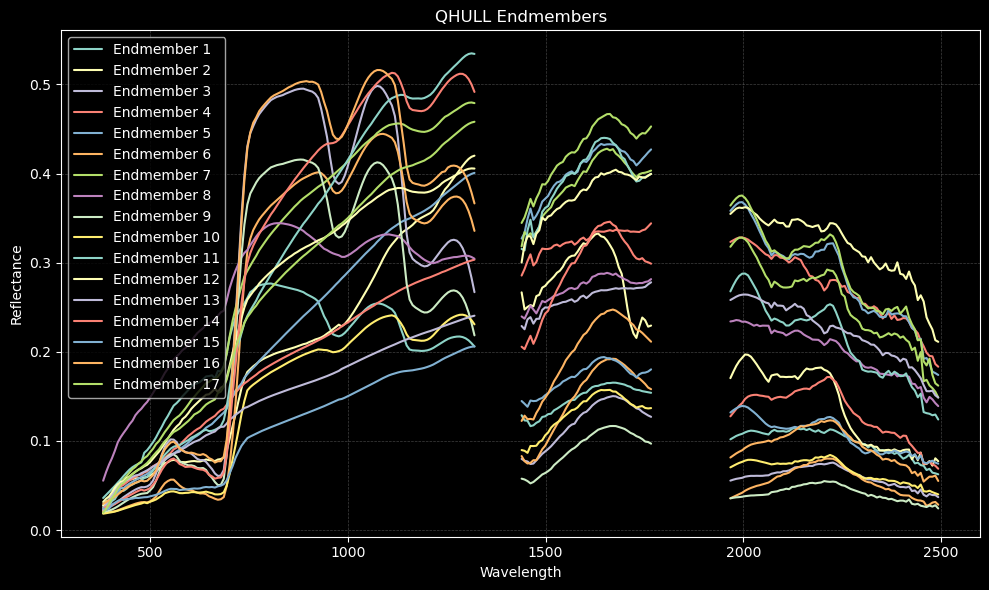

In [7]:
def qhull_endmembers(data,n_components=3):
    """
    Finds the edges of the data simplex using QHULL to find the endmembers.
    
    Parameters:
    data (numpy.ndarray): The input data, expected to be 2D (pixels x bands).
    subsize (int): The maximum number of pixels to use for the analysis.

    Returns:
    realsig (numpy.ndarray): The real signatures from the data.
    """


    # Perform PCA transformation
    pca = PCA(n_components=n_components)
    pc = pca.fit_transform(data)
    
    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f'Cumulative PCA Explained Variance = {cumulative_explained_variance}')
    
    # Use Qhull via ConvexHull to find the extreme points
    # Fx print extreme points (vertices) of convex hulls
    # W0.1 min distance above plane for outside points to approximate the convex hull
    # QbB  - scale the input to fit the unit cube
    hull = ConvexHull(pc, qhull_options='Fx W0.1 QbB')

    # Extract the real signatures
    realsig = data[hull.vertices]


    return realsig

# Use boolean indexing more efficiently by computing mask once
valid_bands = ~np.all(sampled_data < 0, axis=0)

# Get endmembers for valid bands only
S = qhull_endmembers(sampled_data[:, valid_bands], 3)

# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

# Create figure
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    
    # Vectorized plotting using numpy operations
    wavelengths_matrix = np.tile(wavelengths, (endmembers.shape[0], 1)).T
    
    # Plot all lines at once with optimized line properties
    lines = ax.plot(wavelengths_matrix, endmembers.T, 
                   linewidth=1.5,  # Optimal line width for performance
                   solid_capstyle='round',
                   antialiased=True)
    
    ax.set_prop_cycle('color', plt.cm.tab10(np.linspace(0, 1, endmembers.shape[0])))
    
    ax.set(xlabel='Wavelength',
           ylabel='Reflectance',
           title='QHULL Endmembers')
    
    for text in (*ax.get_xticklabels(), *ax.get_yticklabels(),
                ax.xaxis.label, ax.yaxis.label, ax.title):
        text.set_color('white')
    
    ax.legend([f'Endmember {i+1}' for i in range(endmembers.shape[0])],
              framealpha=0.8,
              loc='best',
              ncol=1)

    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout()




Starting with 17 edge members.
Starting optimization to find a convex hull with 5 vertices...
differential_evolution step 1: f(x)= 54.25832383795033
differential_evolution step 2: f(x)= 52.96343209901826
differential_evolution step 3: f(x)= 52.96343209901826
differential_evolution step 4: f(x)= 52.96343209901826
differential_evolution step 5: f(x)= 52.96343209901826
differential_evolution step 6: f(x)= 52.96343209901826
differential_evolution step 7: f(x)= 52.96343209901826
differential_evolution step 8: f(x)= 52.96343209901826
differential_evolution step 9: f(x)= 52.96343209901826
differential_evolution step 10: f(x)= 52.96343209901826
differential_evolution step 11: f(x)= 49.14532984893986
differential_evolution step 12: f(x)= 49.14532984893986
differential_evolution step 13: f(x)= 44.16486451354558
differential_evolution step 14: f(x)= 44.16486451354558
differential_evolution step 15: f(x)= 44.16486451354558
differential_evolution step 16: f(x)= 44.16486451354558
differential_evolut

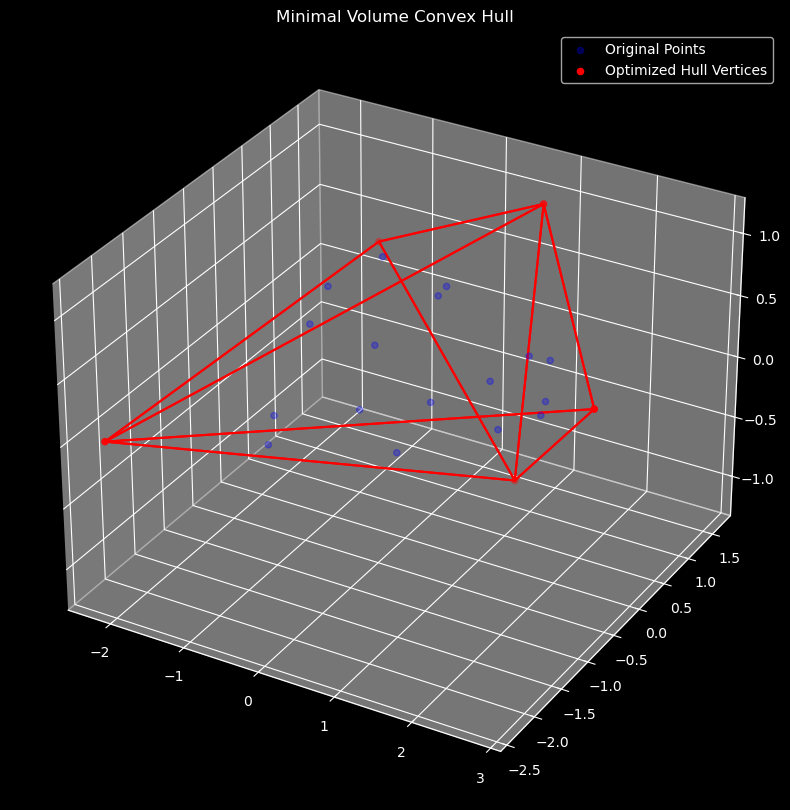

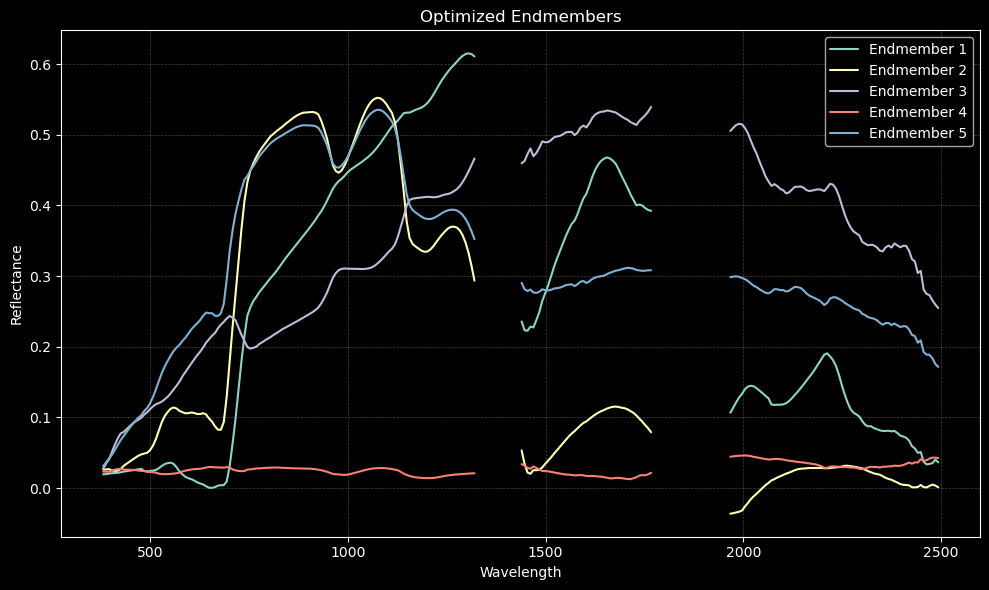

In [ ]:
#%matplotlib widget
%matplotlib inline
"""
Minimal Volume Convex Hull Optimization in 3D

This script finds a minimal-volume convex hull with N vertices that encloses
a given set of 3D points using global optimization (Differential Evolution).

Author: Peter Scarth
Date: 2025-02-18
"""

import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull, Delaunay
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting

def compute_hull_volume(points):
    """
    Compute the volume of the convex hull of given points.

    Parameters:
    - points: ndarray of shape (M, 3).

    Returns:
    - volume: float, volume of the convex hull. Returns np.inf if hull computation fails.
    """
    try:
        hull = ConvexHull(points)
        return hull.volume
    except:
        # If points are coplanar or otherwise degenerate
        return np.inf

def points_inside_hull(original_points, hull_vertices):
    """
    Check which original points are inside the convex hull defined by hull_vertices.

    Parameters:
    - original_points: ndarray of shape (M, 3), points to check.
    - hull_vertices: ndarray of shape (N, 3), vertices of the convex hull.

    Returns:
    - inside: ndarray of shape (M,), boolean array indicating whether each point is inside the hull.
    """
    try:
        delaunay = Delaunay(hull_vertices)
        return delaunay.find_simplex(original_points) >= 0
    except:
        # If the Delaunay triangulation fails (e.g., degenerate hull)
        return np.zeros(len(original_points), dtype=bool)

def define_bounds(original_points, N, padding=1.0):
    """
    Define the bounds for each coordinate of the N new vertices based on the original data.

    Parameters:
    - original_points: ndarray of shape (M, 3), original data points.
    - N: int, number of vertices for the new convex hull.
    - padding: float, extra space added to the bounds.

    Returns:
    - bounds: list of tuples, bounds for each variable in the optimizer.
    """
    mins = original_points.min(axis=0) - padding
    maxs = original_points.max(axis=0) + padding
    bounds = []
    for _ in range(N):
        for dim in range(3):
            bounds.append((mins[dim], maxs[dim]))
    return bounds



def objective(global_variables, original_points, N, penalty_weight=10, pca=None, bound_penalty_weight=1, max_reflectance=1):
    """
    Objective function to minimize: volume of the convex hull + penalties for points outside +
    penalties for inverse-transformed endmembers outside [0, 1].

    Parameters:
    - global_variables: ndarray of shape (3N,), flattened coordinates of N vertices.
    - original_points: ndarray of shape (M, 3), points to be enclosed.
    - N: int, number of vertices for the new convex hull.
    - penalty_weight: float, weight for the penalty term for points outside.
    - pca: PCA object, used for inverse transformation.
    - bound_penalty_weight: float, weight for the penalty term for bound violations.
    - max_reflectance: float, maximum reflectance value for bound violations.

    Returns:
    - total_cost: float, sum of hull volume and penalties.
    """
    # Reshape the variable vector into N x 3 points
    Q = global_variables.reshape((N, 3))
    
    try:
        hull = ConvexHull(Q)
        volume = hull.volume
    except:
        # Assign a large volume if hull computation fails
        return 1e12
    
    # Retrieve the hull vertices for Delaunay triangulation
    hull_vertices = Q[hull.vertices]
    
    # Check which original points are inside the hull
    inside = points_inside_hull(original_points, hull_vertices)
    num_outside = np.size(inside) - np.sum(inside)
    
    # Calculate penalty for points outside
    penalty = penalty_weight * num_outside
    
    # Additional penalty for inverse-transformed endmembers outside [0, Max Reflectance]
    if pca is not None:
        try:
            # Inverse transform to original space
            endmembers = pca.inverse_transform(Q)
            
            # Compute violations: any value <0 or >0.5
            violations = np.sum((endmembers < 0) | (endmembers > max_reflectance))
            
            # Apply penalty for each violation
            penalty += bound_penalty_weight * violations
        except Exception as e:
            # If inverse_transform fails, apply a large penalty
            penalty += 1e6
    
    # Total cost is volume plus penalties
    total_cost = volume + penalty
    
    return total_cost

def find_minimal_convex_hull_global(original_points, N, pca, penalty_weight=10, bound_penalty_weight=1, maxiter=1000, popsize=15, seed=None, max_reflectance=1):
    """
    Find the minimal-volume convex hull enclosing the original points using Differential Evolution.

    Parameters:
    - original_points: ndarray of shape (M, 3), points to enclose.
    - N: int, number of vertices for the new convex hull (must be >=4 for 3D).
    - pca: PCA object, used for inverse transformation.
    - penalty_weight: float, weight for the penalty term for points outside.
    - bound_penalty_weight: float, weight for the penalty term for bound violations.
    - maxiter: int, maximum number of iterations for the optimizer.
    - popsize: int, population size multiplier (default 15).
    - seed: int or None, random seed for reproducibility.

    Returns:
    - optimized_vertices: ndarray of shape (N, 3), optimized positions of hull vertices.
    - result: OptimizeResult object, contains information about the optimization.
    """
    if N < 4:
        raise ValueError("N must be at least 4 to form a 3D convex hull.")
    
    # Define bounds for the optimizer
    bounds = define_bounds(original_points, N, padding=1.0)
    
    # Perform Differential Evolution
    result = differential_evolution(
        func=objective,
        bounds=bounds,
        args=(original_points, N, penalty_weight, pca, bound_penalty_weight, max_reflectance),
        strategy='best1bin',
        maxiter=maxiter,
        popsize=popsize,
        tol=1e-6,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=seed,
        disp=True,
        polish=True,
        init='latinhypercube',
        updating='deferred',  # Improves performance by deferring updates
        workers=1  # Use all available CPU cores
    )
    
    # Extract optimized vertices
    optimized_vertices = result.x.reshape((N, 3))
    return optimized_vertices, result

def plot_convex_hull(original_points, hull_vertices, title='Minimal Volume Convex Hull'):
    """
    Plot the original points and the optimized convex hull in 3D.

    Parameters:
    - original_points: ndarray of shape (M, 3), original data points.
    - hull_vertices: ndarray of shape (N, 3), vertices of the optimized convex hull.
    - title: str, title of the plot.
    """
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot original points
    ax.scatter(original_points[:,0], original_points[:,1], original_points[:,2],
               color='blue', alpha=0.3, label='Original Points')
    
    # Compute convex hull of optimized vertices
    try:
        hull = ConvexHull(hull_vertices)
        for simplex in hull.simplices:
            simplex = np.append(simplex, simplex[0])  # To create a closed loop
            ax.plot(hull_vertices[simplex, 0], hull_vertices[simplex, 1], hull_vertices[simplex, 2],
                    'r-')
        
        # Optionally, plot the vertices
        ax.scatter(hull_vertices[:,0], hull_vertices[:,1], hull_vertices[:,2],
                   color='red', label='Optimized Hull Vertices')
    except Exception as e:
        print("Failed to compute convex hull for visualization:", e)
    
    ax.set_title(title)
    ax.legend()
    
    plt.show()

def plot_endmembers(wavelengths, endmembers, title = ''):
    """
    Plot endmember spectra with wavelengths.
    
    Parameters:
    - wavelengths: ndarray of shape (n_bands,), wavelength values
    - endmembers: ndarray of shape (n_endmembers, n_bands), endmember spectra
    """
    with plt.style.context('dark_background'):
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        
        # Vectorized plotting using numpy operations
        wavelengths_matrix = np.tile(wavelengths, (endmembers.shape[0], 1)).T
        
        # Plot all lines at once with optimized line properties
        lines = ax.plot(wavelengths_matrix, endmembers.T, 
                       linewidth=1.5,  # Optimal line width for performance
                       solid_capstyle='round',
                       antialiased=True)
        
        ax.set_prop_cycle('color', plt.cm.tab10(np.linspace(0, 1, endmembers.shape[0])))
        
        ax.set(xlabel='Wavelength',
               ylabel='Reflectance',
               title=title)
        
        for text in (*ax.get_xticklabels(), *ax.get_yticklabels(),
                    ax.xaxis.label, ax.yaxis.label, ax.title):
            text.set_color('white')
        
        ax.legend([f'Endmember {i+1}' for i in range(endmembers.shape[0])],
                  framealpha=0.8,
                  loc='best',
                  ncol=1)

        ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        fig.tight_layout()


# Find the edgemembers
valid_bands = ~np.all(sampled_data < 0, axis=0)
pca = PCA(n_components=3)
pc = pca.fit_transform(sampled_data[:, valid_bands])

# Get at least start_vertices edge members
start_vertices = 25
w_val=0.5
num_vertices = 4
while num_vertices < start_vertices:
    hull = ConvexHull(pc, qhull_options=f'Fx W{w_val} QbB')
    num_vertices = len(hull.vertices)
    w_val -= 0.01

print(f"Found {num_vertices} edge members with w={w_val:.2f}")
edgemembers = pc[hull.vertices]
print(f"Starting with {len(edgemembers)} edge members.")

# Parameters
N = 5 # Number of vertices for the new convex hull (>=4)
penalty_weight = 5.0 # Penalty for points outside the hull
bound_penalty_weight = 0.1 # Penalty for inverse-transformed endmembers outside [0, 1]      
maxiter = 100000 # Maximum number of iterations for the optimizer
popsize = 15 # Population size multiplier
seed = None # Random seed for reproducibility

# Find minimal convex hull using global optimizer
print(f"Starting optimization to find a convex hull with {N} vertices...")
optimized_vertices, optimization_result = find_minimal_convex_hull_global(
    edgemembers,
    N=N,
    pca=pca,
    penalty_weight=penalty_weight,
    bound_penalty_weight=bound_penalty_weight,
    maxiter=maxiter,
    popsize=popsize,
    seed=seed,
    max_reflectance=0.7
)

# Display optimization results
print("\nOptimization Results:")
print(f"Success: {optimization_result.success}")
print(f"Message: {optimization_result.message}")
print(f"Number of Function Evaluations: {optimization_result.nfev}")
final_volume = compute_hull_volume(optimized_vertices)
print(f"Final Volume of Optimized Convex Hull: {final_volume:.4f}")

# Verify that all points are inside the optimized hull
try:
    hull = ConvexHull(optimized_vertices)
    hull_vertices = optimized_vertices[hull.vertices]
    inside = points_inside_hull(edgemembers, hull_vertices)
    num_inside = np.sum(inside)
    print(f"Number of Original Points Inside the Optimized Hull: {num_inside} / {len(edgemembers)}")
except Exception as e:
    print("Failed to verify point enclosure:", e)

# Plot the results
plot_convex_hull(edgemembers, optimized_vertices, title='Minimal Volume Convex Hull')

    

# Use the inverse PCA transformation to get the endmembers in the original space
S = pca.inverse_transform(hull_vertices)
# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

plot_endmembers(wavelengths, endmembers, title='Optimized Endmembers')



# Save the PCA, the optimized vertices, and the endmembers
joblib.dump(pca, 'pca.joblib')
np.save('optimized_vertices.npy', optimized_vertices)
np.save('endmembers.npy', endmembers)





## Unmixing

In [ ]:
import numpy as np
from rios import applier
from rios import fileinfo
from rios import cuiprogress
from scipy.optimize import nnls
import matplotlib.pyplot as plt
from osgeo import gdal

gdal.UseExceptions()


# The paths to the input and output files
refDataPath = 'EMIT_L2A_RFL_001_20240721T024222_2420301_008_reflectance.tif'
unmixDataPath = 'EMIT_L2A_RFL_001_20240721T024222_2420301_008_unmixed.tif'


def _nnls_unmix(info, inputs, outputs, otherargs):
    nbar = inputs.nbar[otherargs.valid_bands]
    mask = np.all(nbar == otherargs.noData, axis=0)

    # Flatten reflectance and perform PCA in one step to save memory
    original_shape = nbar.shape
    nbar_transformed = otherargs.pca.transform(nbar.reshape(original_shape[0], -1).T).T

    # Precompute ones array outside the loop
    ones_array = np.full((1, nbar_transformed.shape[1]), otherargs.sum_to_one)

    # Combine weighted reflectance with ones_array using np.vstack
    weightedReflectance = np.vstack((nbar_transformed, ones_array))

    # Initialize fractions array with zeros
    fractions = np.zeros((otherargs.weighted_endmembers.shape[1], nbar_transformed.shape[1]), dtype=np.float32)

    # Use vectorization where possible
    for i in range(weightedReflectance.shape[1]):
        fractions[:, i], _ = nnls(otherargs.weighted_endmembers, weightedReflectance[:, i])

    # Reshape, clip, and convert to 8-bit data
    fractions = np.clip(np.rint(100.0 * fractions.reshape((-1,original_shape[1], original_shape[2]))), 0, 200).astype('uint8')

    # Compute fractions for bare, green, dry vegetation
    fractions_bgd = np.zeros((3, original_shape[1], original_shape[2]), dtype=np.uint8)
    fractions_bgd[0] = fractions[otherargs.bare_green_dry[0]].sum(axis=0)
    fractions_bgd[1] = fractions[otherargs.bare_green_dry[1]].sum(axis=0)
    fractions_bgd[2] = fractions[otherargs.bare_green_dry[2]].sum(axis=0)

    # Apply mask
    fractions_bgd[:, mask] = 255
    fractions[:, mask] = 255

    # Write the output
    outputs.fractions = fractions_bgd



# Setup inputs, outputs, and other configurations
sum_to_one = 5
pca = joblib.load('pca.joblib')
optimized_vertices = np.load('optimized_vertices.npy')
weighted_endmembers = np.vstack((optimized_vertices.T, np.ones(optimized_vertices.shape[0]) * sum_to_one))
bare_green_dry = [[0,2], [1], [3]] # Bare, green, dry endmember mapping


infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()
infiles.nbar = refDataPath
outfiles.fractions = unmixDataPath

otherargs = applier.OtherInputs()
otherargs.noData = noData
otherargs.pca = pca
otherargs.weighted_endmembers = weighted_endmembers
otherargs.valid_bands = valid_bands
otherargs.sum_to_one = sum_to_one
otherargs.bare_green_dry = bare_green_dry

controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512
controls.progress = cuiprogress.CUIProgressBar()
controls.setStatsIgnore(255)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=1",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

rtn = applier.apply(_nnls_unmix, infiles, outfiles, otherargs, controls=controls)


### NMF

TODO - Make this work :)

/home/pete/miniconda3/envs/emit/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


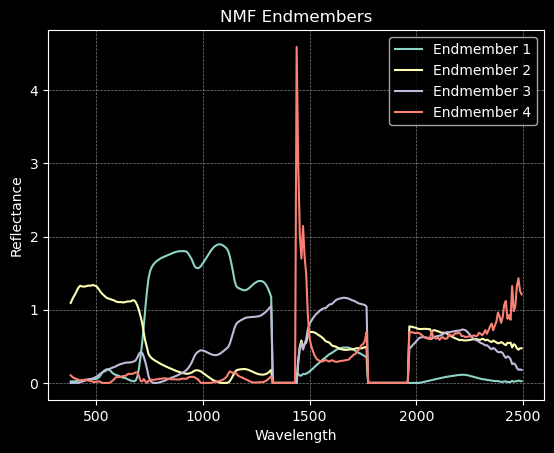

In [ ]:
# User NMF to extract endmembers
from sklearn.decomposition import NMF

sampled_positive = np.clip(sampled_data, 0, None)
# Subsample the data to 1000 pixels
sampled_positive = sampled_positive[np.random.choice(sampled_positive.shape[0], 10000, replace=False)]


 # Compute the NMF
nmf = NMF(n_components=4, init='nndsvd', max_iter=1000)
W = nmf.fit_transform(sampled_positive)
H = nmf.components_


# Plot the endmembers
plt.style.use('dark_background')
for i in range(H.shape[0]):
    endmember = H[i]
    endmember[endmember < 0] = np.nan
    plt.plot(wavelengths, endmember, label=f'Endmember {i+1}')
plt.xlabel('Wavelength', color='white')
plt.ylabel('Reflectance', color='white')
plt.title('NMF Endmembers', color='white')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)


## Samping EMIT and ENMAP

In [ ]:
def getBandDescriptions(rasterName):
    """
    Get the band descriptions from the raster metadata.
    """
    ds = gdal.Open(rasterName)
    band_descriptions = []
    for i in range(1, ds.RasterCount + 1):
        band = ds.GetRasterBand(i)
        band_descriptions.append(band.GetDescription())
    return band_descriptions





def getPixelSample(info, inputs, outputs, otherargs):
    """
    Helper Function. Called from RIOS and randomly subsamples
     the data to about SUBSAMPLE pixels
    """
    enmap = inputs.enmap
    emit = inputs.emit
    emit = emit.reshape((emit.shape[0],-1)).T
    enmap = enmap.reshape((enmap.shape[0],-1)).T
    # Get the nodata id emit or enmap is nodata
    nodata = np.all(emit == 0, axis=1) | np.all(enmap == -32768, axis=1)
    emit = emit[~nodata]
    enmap = enmap[~nodata]
    numSamples = len(emit)
    if numSamples > 0:
        # choose a random subset of the data based on how much data
        # in this block
        emit_sample = emit[np.random.choice(numSamples, size=int(numSamples / otherargs.sampleFraction), replace=False)]
        enmap_sample = enmap[np.random.choice(numSamples, size=int(numSamples / otherargs.sampleFraction), replace=False)]
        otherargs.emitsample.append(emit_sample)
        otherargs.enmapsample.append(enmap_sample)


def subSampleRaster(emitName, enmapName, subsample):
    """
    Samples about SUBSAMPLE pixels from the given raster
    Using the getPixelSample funtion in RIOS
    """
    # Use fileinfo
    raster_info = fileinfo.ImageInfo(emitName)
    cols = raster_info.ncols
    rows = raster_info.nrows
    noData = raster_info.nodataval[0]

    # Set up input and output filenames.
    infiles = applier.FilenameAssociations()
    outfiles = applier.FilenameAssociations()
    infiles.emit = emitName
    infiles.enmap = enmapName

    otherargs = applier.OtherInputs()
    otherargs.noData = noData
    # calculate the fraction of the whole image this is
    otherargs.sampleFraction = (cols * rows) / subsample
    otherargs.emitsample = []
    otherargs.enmapsample = []
    controls = applier.ApplierControls()
    controls.windowxsize = 128
    controls.windowysize = 128
    controls.setResampleMethod("near")
    controls.setReferenceImage(rasterNames[0])

    applier.apply(getPixelSample, infiles, outfiles, otherargs, controls=controls)
    # Concatenate the list of samples into a numpy array
    emit_sample = np.concatenate(otherargs.emitsample)
    enmap_sample = np.concatenate(otherargs.enmapsample)
    return emit_sample, enmap_sample


EMIT_FILE = 'EMIT_L2A_RFL_001_20240721T024222_2420301_008_reflectance.tif'
ENMAP_FILE = 'ENMAP01-____L2A-DT0000083436_20240721T0054.vrt'

# Put the higher res first

emit_sample, enmap_sample = subSampleRaster(EMIT_FILE, ENMAP_FILE, 10000)

# Save the sample data
np.save('emit_sample.npy', emit_sample)
np.save('enmap_sample.npy', enmap_sample)





In [ ]:
# Load the sample data

emit_sample = np.load('emit_sample.npy')
enmap_sample = np.load('enmap_sample.npy') / 10000

# Use a masked array to mask all the values less or equal to 0
emit_sample = np.ma.masked_less_equal(emit_sample, 0)
enmap_sample = np.ma.masked_less_equal(enmap_sample, 0)

# Hack to get the wavelengths
emit_wavelengths = np.array([float(w) for w in getBandDescriptions('EMIT_L2A_RFL_001_20240721T024222_2420301_008_reflectance.tif')])
enmap_wavelengths = np.array([float(w) for w in getBandDescriptions('ENMAP01-____L2A-DT0000083436_20240721T005423Z_011_V010402_20240724T081453Z-SPECTRAL_IMAGE_COG_BSQ.tif')])

# Break the two spectrometers into their own arrays
enmap_nir_wavelengths = enmap_wavelengths[:91]
enmap_swir_wavelengths = enmap_wavelengths[91:]
enmap_nir_sample = enmap_sample[:, :91]
enmap_swir_sample = enmap_sample[:, 91:]



#plot the mean spectra of emit and enmap


# Make a wide plot
plt.figure(figsize=(6, 4))

plt.plot(emit_wavelengths, emit_sample.mean(axis=0), label='EMIT', color='orange')
plt.plot(enmap_nir_wavelengths, enmap_nir_sample.mean(axis=0), label='ENMAP NIR', color='blue')
plt.plot(enmap_swir_wavelengths, enmap_swir_sample.mean(axis=0), label='ENMAP SWIR', color='red')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Mean Spectra of EMIT and ENMAP')
plt.legend()
plt.grid(True)



